In [84]:
import cv2  # OpenCV for image processing
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation (optional, but useful for organizing results)
import os
import random
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, average_precision_score, pairwise_distances
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.decomposition import PCA

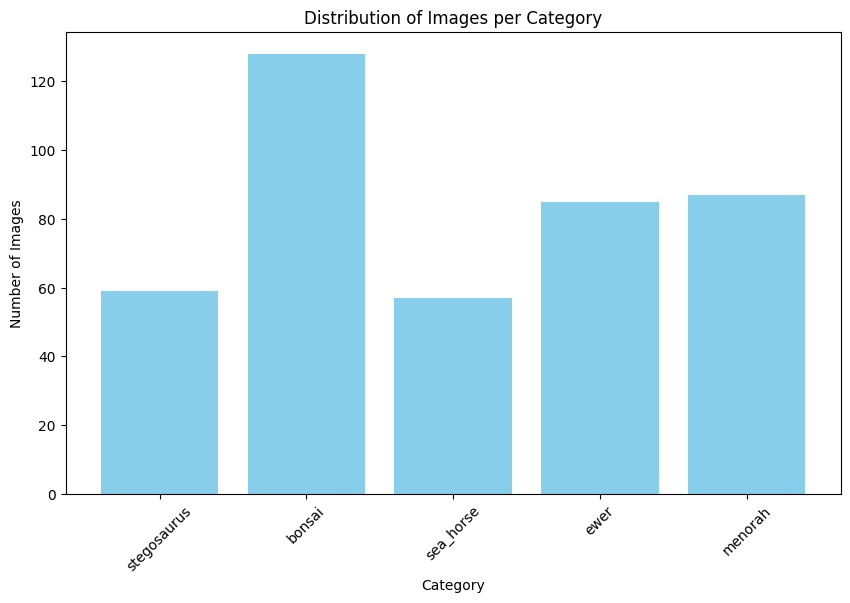

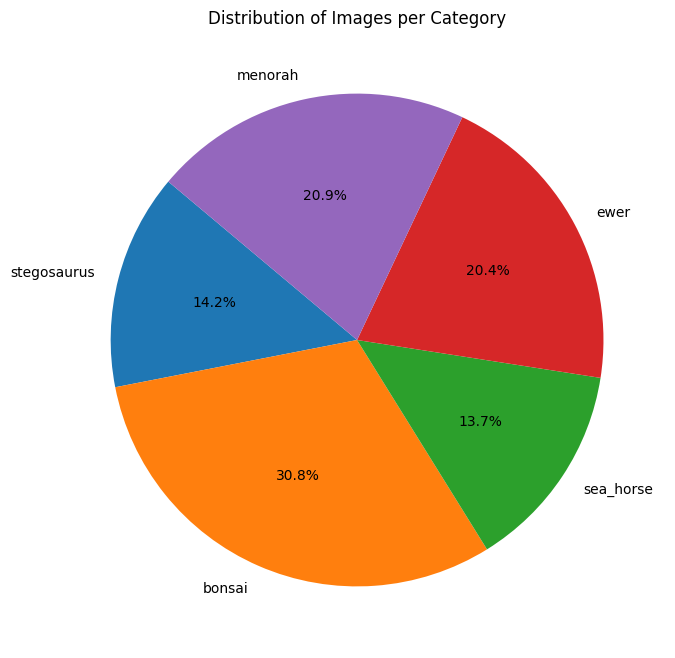

In [85]:
# Define the folder path
folder_path = r"ObjectCategories/101_ObjectCategories"
folder_contents = os.listdir(folder_path)
folder_names = [name for name in folder_contents if os.path.isdir(os.path.join(folder_path, name))]

# Select categories with at least 50 images
randomsa = []
for folder_name in folder_names:
    folder_contents = os.listdir(os.path.join(folder_path, folder_name))
    if len(folder_contents) >= 50:
        randomsa.append(folder_name)

# Select 5 random categories
selected_folders = random.sample(randomsa, 5)

# Create a new directory to organize the selected categories
organized_folder_path = r"organized_caltech101"
if os.path.exists(organized_folder_path):
    shutil.rmtree(organized_folder_path)
os.makedirs(organized_folder_path)

# Organize the selected categories into separate folders
for folder_name in selected_folders:
    src_folder = os.path.join(folder_path, folder_name)
    dest_folder = os.path.join(organized_folder_path, folder_name)
    os.makedirs(dest_folder, exist_ok=True)
    for file_name in os.listdir(src_folder):
        src_file = os.path.join(src_folder, file_name)
        dest_file = os.path.join(dest_folder, file_name)
        shutil.copy(src_file, dest_file)

# Analyze and plot the distribution of images per category
category_counts = {folder_name: len(os.listdir(os.path.join(organized_folder_path, folder_name))) for folder_name in selected_folders}

# Plotting the distribution using a bar graph
plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Category')
plt.xticks(rotation=45)
plt.show()

# Plotting the distribution using a pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images per Category')
plt.show()

In [86]:
def loadPreProcess(image_path, canny_low, canny_high):
    if(os.path.exists(image_path)):
        # Load the image as gray scale
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE )
        # resize the image for uniform feature length
        resized = cv2.resize(image, (256,128), interpolation=cv2.INTER_AREA)

        # Apply Gaussian Blur
        blurred = cv2.GaussianBlur(resized, (5, 5), 0)
        # Apply Canny for edge detection
        return cv2.Canny(blurred, canny_low, canny_high)
    else:
        return []

In [87]:
def getHOGFeatures(image, cellSize, blockSize, blockStride):
    winSize = (256,128) # scaled image size
    nbins = 9

    # HOG from preprocessed image
    hog = cv2.HOGDescriptor(_winSize = winSize, _cellSize = cellSize, _blockSize = blockSize, _nbins= nbins, _blockStride = blockStride)
    return hog.compute(image)

In [88]:
def loadData(base_path, folder_names, params):
    features = list()
    category = list()
    image_names = list()
    for folder_name in folder_names:
        folder_path = os.path.join(base_path, folder_name)
        # get and extract feature from all files in current folder
        for file_name in os.listdir(folder_path):
            image = loadPreProcess(os.path.join(folder_path, file_name), params['canny_low'], params['canny_high'])
            features.append(getHOGFeatures(image, params['cell_size'], params['block_size'], params['block_stride']))
            category.append(folder_name)
            image_names.append(file_name)

    # z-score normalization feature set
    scaler = StandardScaler()
    norm_data = scaler.fit_transform(features)

    # PCA to reduce dimentionality
    pca = PCA(n_components=0.98)
    pca_data = pca.fit_transform(norm_data)

    data = pd.DataFrame(pca_data)
    data['category'] = category
    data['image_name'] = image_names

    return data

In [89]:
def train(train_x, train_y):
    # define model
    model = SVC()

    # Define the parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'linear', 'sigmoid']
    }

    # k-fold with grid search cross validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='accuracy')
    grid_search.fit(train_x, train_y)
    
    print("Best Cross-Validation Accuracy:", grid_search.best_score_)
    model.fit(train_x, train_y)
    return model

In [90]:
def calcultate_map(test_y,pred_y):
    binarized_test_y = label_binarize(test_y, classes=np.unique(test_y))
    binarized_pred_y = label_binarize(pred_y, classes=np.unique(test_y))
    ap_scores = []
    for i in range(binarized_test_y.shape[1]):
        ap = average_precision_score(binarized_test_y[:, i], binarized_pred_y[:, i])
        ap_scores.append(ap)
    
    map_score = np.mean(ap_scores)
    return map_score

In [91]:
def test(model, test_x, test_y):
    pred_y = model.predict(test_x)
    # Calculate metrics
    accuracy = accuracy_score(test_y, pred_y)
    precision = precision_score(test_y, pred_y, average='weighted')
    recall = recall_score(test_y, pred_y, average='weighted')
    f1 = f1_score(test_y, pred_y, average='weighted')
    map_score = calcultate_map(test_y, pred_y)

    # 8. Analysis and Discussion
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    print(f"MAP: {map_score}")

In [92]:
def get_top_k_similar_images(model, source, image_data, k=5):
    pred_cat = model.predict(image_data)
    distances = pairwise_distances(source, image_data, metric='cosine').ravel()
    top_k_indices = np.argsort(distances)[:-k]
    return pred_cat, top_k_indices

In [93]:
feature_params_1  ={
    'canny_low': 50,
    'canny_high': 150,
    'cell_size' : (16,16), # in pixel
    'block_size' : (32,32), # multiple of cell size
    'block_stride':(16,16) # multiple of cell size
}

data_1 = loadData(organized_folder_path, category_counts.keys(), feature_params_1)
vector_1 =data_1.iloc[:, :-2]
category = data_1.iloc[:, -2]

In [94]:
train_x, test_x, train_y, test_y = train_test_split(vector_1, category, train_size=0.8, stratify=category )
model = train(train_x, train_y)
test(model, test_x, test_y)

Best Cross-Validation Accuracy: 0.7561736770691996
Accuracy: 0.7619047619047619
Precision: 0.7763145798860085
Recall: 0.7619047619047619
F1-score: 0.7421346023789632
MAP: 0.6106778047954518


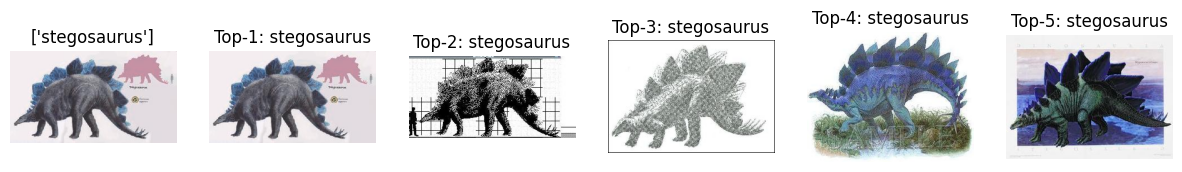

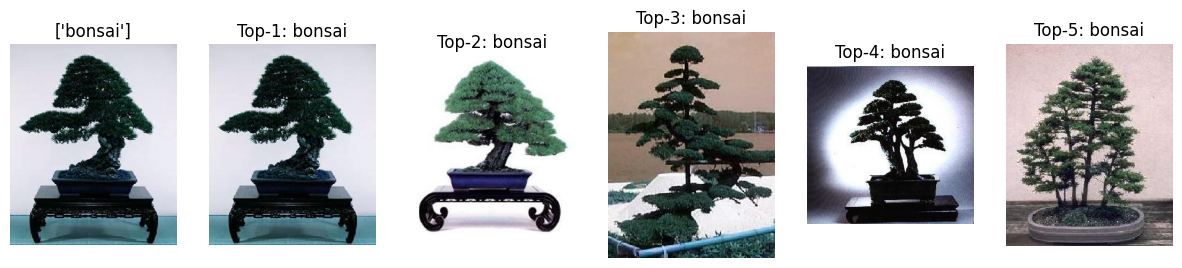

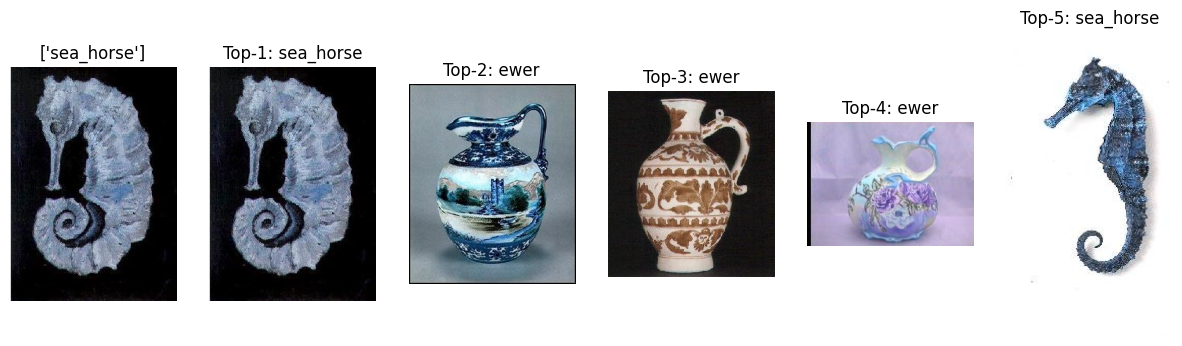

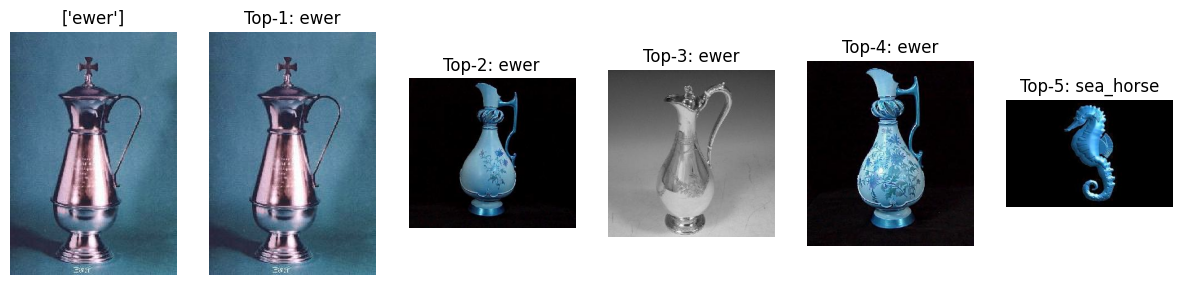

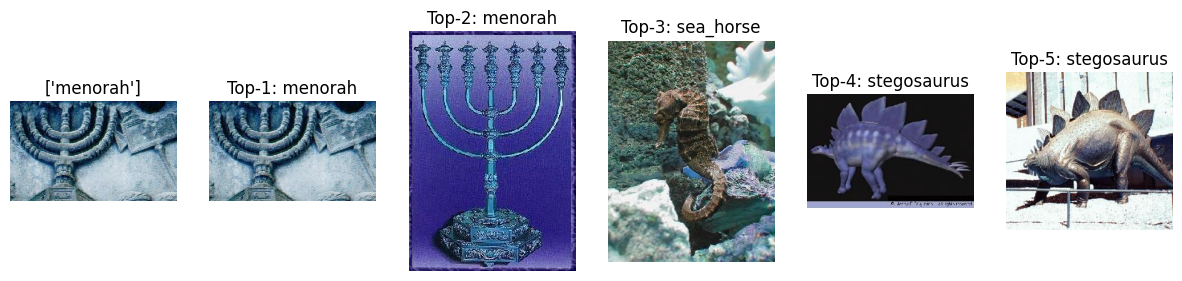

In [95]:
# Randomly select 5 test images from each selected folder
for folder in selected_folders:
    folder_dir = os.path.join(organized_folder_path, folder)
    file_name = random.sample(os.listdir(folder_dir), 1)[0]
    image_data = data_1.query(f"category ==  '{folder}' & image_name == '{file_name}'").iloc[:,:-2]
    pred_label, top_k_match = get_top_k_similar_images(model, vector_1, image_data)

    # Display query image and top-5 retrieved images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 6, 1)
    plt.imshow(cv2.imread(os.path.join(folder_dir, file_name)), cmap='gray')
    plt.title(pred_label)
    plt.axis('off')
    
      
    for i in range(5):
        category = data_1.iloc[top_k_match[i]]['category']
        file_name = data_1.iloc[top_k_match[i]]['image_name']
        img = cv2.imread(os.path.join(organized_folder_path, category, file_name))
        plt.subplot(1, 6, i + 2)
        plt.imshow(img, cmap='gray')
        plt.title(f"Top-{i+1}: {category}")
        plt.axis('off')
    
    plt.show()